In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys

In [131]:
def get_windows(data, annots, window_size):    
    step_size = window_size//3
    annot_count = len(annots)
    sample_count = len(data)
    indices = np.arange(0, sample_count-window_size, step_size)
    window_count = len(indices)
    windows = np.zeros((window_count, window_size, data.shape[1]))
    labels = np.zeros((window_count, ))
    features = np.zeros((window_count, 2))
    cut_points = np.zeros((window_count, 5))
    
    lab = True if annots.shape[1]==2 else False 
    
    annot_index = 0    
    for i in range(window_count):
        si = indices[i]
        windows[i, :, :] = (data[si:si+window_size, :]+9.8)/(2*9.8)
        
        mid_start = si + step_size
        mid_end = mid_start + step_size-1
        
        features[i, 0] = np.amin(data[mid_start:mid_end+1, 0])
        features[i, 1] = np.sum(np.var(data[si:si+window_size, :], axis=0))
        
        cut_points[i, :] = [si, mid_start, mid_end, si+window_size-1, 0]        
                
        if lab and annot_index < annot_count and annots[annot_index, 0] < si+window_size:            
            if annots[annot_index, 0] > mid_end:
                labels[i] = -1
                
            elif mid_start <= annots[annot_index, 0] <= mid_end:
                labels[i] = annots[annot_index, 1]
                cut_points[i, 4] = annots[annot_index, 0]
                
            elif si <= annots[annot_index, 0] < mid_start:
                labels[i] = -1                
                annot_index = annot_index + 1
                while annot_index < annot_count and annots[annot_index, 0] < mid_start: 
                    annot_index = annot_index + 1
                    
                if annot_index < annot_count and mid_start <= annots[annot_index, 0] <= mid_end:
                    labels[i] = annots[annot_index, 1]
                    cut_points[i, 4] = annots[annot_index, 0]
                
            else:
                print("Annot time error")
                sys.exit(0)
                
        elif (not lab) and annot_index < annot_count and annots[annot_index, 0] < si+window_size:
            if si > annots[annot_index, 1]:
                annot_index += 1
            else:
                if annots[annot_index, 2] <3:
                    labels[i] = 1
                else:
                    labels[i] = 2
                
    return windows, labels, features, cut_points            

In [132]:
def get_windows_dataset(ds, window_size):
    windows = []
    labels = []
    features = []
    cut_points = []
    subject_session = []
    for subject in range(len(ds)):
        for sess in range(len(ds[subject])):
            accel = ds[subject][sess][0]
            annots = ds[subject][sess][1]
          
            w, l, f, c = get_windows(accel[:, 1:], annots, window_size)            
            ss = np.zeros((len(l), 2))
            ss[:, 0] = subject
            ss[:, 1] = sess
            
            if len(windows)==0:
                windows = w
                labels = l
                features = f
                cut_points = c
                subject_session = ss
                
            else:
                windows = np.concatenate((windows, w), axis=0)
                labels = np.concatenate((labels, l), axis=0)
                features = np.concatenate((features, f), axis=0)
                cut_points = np.concatenate((cut_points, c), axis=0)
                subject_session = np.concatenate((subject_session, ss), axis=0)
                
    return windows, labels, features, cut_points, subject_session

In [141]:
def process_annots(annots, min_distance):    
    count = len(annots)
    flags = np.ones((count, ))
    
    for i in range(1, count):
        if annots[i, 0] - annots[i-1, 0]<=min_distance:
            flags[i-1] = 0
            
    annots = annots[flags==1]
    #print('Annnot prcess: before, after :: ', count, len(annots))
    return annots
            
    
def process_annots_dataset(ds, min_distance):
    for subject in range(len(ds)):
        for sess in range(len(ds[subject])):            
            annots = ds[subject][sess][1]
            ds[subject][sess][1] = process_annots(annots, min_distance)            
    return ds
    
def process_uva_lab_data(data, min_distance):
    #usc:0-13, uva: 2, 5, 2, 2, 4, 5, 1
    data[14] = [data[14][0], data[15][0]]
    data[15] = [data[16][0], data[17][0], data[18][0], data[19][0], data[20][0]]
    data[16] = [data[21][0], data[22][0]]
    data[17] = [data[23][0], data[24][0]]
    data[18] = [data[25][0], data[26][0], data[27][0], data[28][0]]
    data[19] = [data[29][0], data[30][0], data[31][0], data[32][0], data[33][0]]
    data[20] = data[34]
    data = data[:21]
    data = process_annots_dataset(data, min_distance)
    return data    

In [142]:
root_path ='C:/ASM/DevData/eating/eating_detection/'
with open(root_path + "data/steven_lab_data.pkl", 'rb') as file:
    stev_lab_data = pickle.load(file)
with open(root_path + "data/uva_lab_data.pkl", 'rb') as file:
    uva_lab_data = pickle.load(file)
    uva_lab_data = process_uva_lab_data(uva_lab_data, 16)

print(len(stev_lab_data), len(uva_lab_data))    
stev_lab_data.extend(uva_lab_data)
lab_data = stev_lab_data
print(len(lab_data))

7 21
28


In [146]:
windows, labels, features, cut_points, subject_session = get_windows_dataset(lab_data, 16*6)

In [138]:
print(windows.shape, labels.shape, features.shape, cut_points.shape, subject_session.shape)
a = labels
print(len(a), np.sum(a==0), np.sum(a==1), np.sum(a==2), np.sum(a==3), np.sum(a<0))

(23401, 96, 3) (23401,) (23401, 2) (23401, 5) (23401, 2)
23401 16459 1769 692 0 4481


f = features[labels>0, 0]
plt.hist(f, bins=100)
plt.show()

f = features[labels==0, 0]
plt.hist(f, bins=100)
plt.show()

In [149]:
l = labels
print(len(l[l==0]), len(l[l>0]))

m = features[:, 0]
v = features[:, 1]
l = labels[m<=-3]
print(len(l[l==0]), len(l[l>0]))

l = labels[ (m<=-3) & (v>=0.1)]
print(len(l[l==0]), len(l[l==1]), len(l[l==2]))


143837 3888
52192 3808
36294 2932 863


In [124]:
ds = stev_free_data
d = np.empty((0, 3))
for subject in range(len(ds)):
    for sess in range(len(ds[subject])):
        accel = ds[subject][sess][0]
        annots = ds[subject][sess][1]
        d = np.concatenate((d, accel[:, 1:]))        

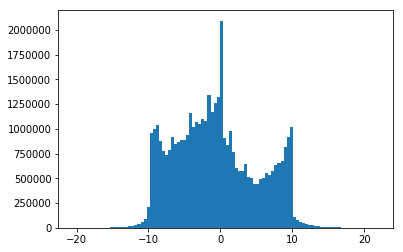

In [125]:
plt.hist(d.reshape((-1,)), bins=100)
plt.show()